In [67]:
import fastf1
import pandas as pd
import numpy as np
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Basically just setups
DATA_FILENAME = 'f1_undercut_data_full_2.csv'

cache_folder_name = 'cache'

if not os.path.exists(cache_folder_name):
    os.makedirs(cache_folder_name)

fastf1.Cache.enable_cache(cache_folder_name) 

print("Cache enabled!")

Cache enabled successfully!


## Data retrieval from the fast-f1 api

In [68]:
def process_season(year):
    print(f"\n--- PROCESSING SEASON {year} ---")
    try:
        schedule = fastf1.get_event_schedule(year)
    except Exception as e:
        print(f"Error fetching schedule for {year}: {e}")
        return []

    season_data = []
    races = schedule[schedule['RoundNumber'] > 0]
    
    for _, race_event in races.iterrows():
        round_num = race_event['RoundNumber']
        gp_name = race_event['EventName']
        
        print(f"  > Loading Round {round_num}: {gp_name}...")
        
        try:
            # Load session (telemetry=False for speed)
            session = fastf1.get_session(year, round_num, 'R')
            session.load(telemetry=False, weather=False, messages=False)
            
            if session.laps.empty:
                print("    [Skipped] No lap data found.")
                continue
                
            # Process the race
            race_dataset = process_race_laps(session.laps, year, gp_name)
            season_data.extend(race_dataset)
            
            # Sleep to respect API rate limits
            time.sleep(2) 
            
        except Exception as e:
            print(f"    [Error] Could not process {gp_name}: {e}")
            time.sleep(2)
            continue
            
    return season_data

In [ ]:
def process_race_laps(laps, year, gp_name):
    race_data = []
    if 'PitOutTime' not in laps.columns: return []

    pit_laps_only = laps[laps['PitOutTime'].notna()]
    if pit_laps_only.empty: return []

    # I just use median to avoid outliers (Safety Cars, crashes)
    normal_laps = laps[laps['PitOutTime'].isna()]['LapTime'].median()
    pitting_laps_avg = pit_laps_only['LapTime'].median()
    
    if pd.notna(normal_laps) and pd.notna(pitting_laps_avg):
        avg_pit_loss = (pitting_laps_avg - normal_laps).total_seconds()
    else:
        avg_pit_loss = 22.0 # This is just a default if its missing a value

    avg_pit_lap_table = pit_laps_only.groupby('Compound')['LapNumber'].mean()
    
    drivers = laps['Driver'].unique()
    
    for drv in drivers:
        drv_laps = laps[laps['Driver'] == drv]
        pit_laps = drv_laps[drv_laps['PitOutTime'].notna()]['LapNumber'].tolist()
        
        for pit_lap in pit_laps:
            # 1. Lap before pit
            pre_pit_lap = pit_lap - 1
            if pre_pit_lap < 1: continue 
            
            try:
                my_state_mask = (laps['Driver'] == drv) & (laps['LapNumber'] == pre_pit_lap)
                if not my_state_mask.any(): continue
                my_state = laps.loc[my_state_mask].iloc[0]
                
                my_pos = my_state['Position']
                my_compound = my_state['Compound']
                my_time = my_state['Time']
            except IndexError: continue
                
            # 2. Get the rival
            rival_pos = my_pos - 1
            if rival_pos < 1: continue 
            
            rival_mask = (laps['LapNumber'] == pre_pit_lap) & (laps['Position'] == rival_pos)
            if not rival_mask.any(): continue
            rival_state_row = laps.loc[rival_mask]
            
            rival_driver = rival_state_row.iloc[0]['Driver']
            rival_laps = laps[laps['Driver'] == rival_driver]
            
            # 3. Calculate Core Features
            gap_to_ahead = (my_time - rival_state_row.iloc[0]['Time']).total_seconds()
            pace_delta = my_state['LapTime'].total_seconds() - rival_state_row.iloc[0]['LapTime'].total_seconds()
            rival_tyre_age = rival_state_row.iloc[0]['TyreLife']
            
            if my_compound in avg_pit_lap_table:
                aggression = avg_pit_lap_table[my_compound] - pit_lap
            else:
                aggression = 0



            # --------------- This is the is traffic feature engineering ----------------------------------
            is_traffic = 0
            
            leader_row = laps[(laps['LapNumber'] == pre_pit_lap) & (laps['Position'] == 1)]
            
            if not leader_row.empty:
                leader_time = leader_row.iloc[0]['Time']
                
                my_gap_to_leader = (my_time - leader_time).total_seconds()
                predicted_gap_to_leader = my_gap_to_leader + avg_pit_loss
                other_cars = laps[laps['LapNumber'] == pre_pit_lap]
                
                for _, car in other_cars.iterrows():
                    if car['Driver'] == drv or car['Driver'] == rival_driver:
                        continue
                        
                    car_gap_to_leader = (car['Time'] - leader_time).total_seconds()
                    distance_metric = abs(car_gap_to_leader - predicted_gap_to_leader)
                    
                    if distance_metric < 1.5:
                        is_traffic = 1
                        break

            # 4. Execution Metrics
            pit_lap_mask = (laps['Driver'] == drv) & (laps['LapNumber'] == pit_lap)
            if not pit_lap_mask.any(): continue
            pit_lap_data = laps.loc[pit_lap_mask].iloc[0]
            
            if 'PitStopDuration' in pit_lap_data and pd.notna(pit_lap_data['PitStopDuration']):
                stationary_duration = pit_lap_data['PitStopDuration']
            else:
                stationary_duration = np.nan 
            
            in_lap_sec = pit_lap_data['LapTime'].total_seconds()
            
            out_lap_mask = (laps['Driver'] == drv) & (laps['LapNumber'] == pit_lap + 1)
            if not out_lap_mask.any(): continue
            out_lap_sec = laps.loc[out_lap_mask].iloc[0]['LapTime'].total_seconds()

            # 5. Undercut Definition
            rival_pit_window = range(int(pit_lap) + 1, int(pit_lap) + 6)
            rival_pit_row = rival_laps[rival_laps['LapNumber'].isin(rival_pit_window) & (rival_laps['PitOutTime'].notna())]
            
            is_undercut_attempt = not rival_pit_row.empty
            
            success = 0
            if is_undercut_attempt:
                rival_pit_lap_num = rival_pit_row.iloc[0]['LapNumber']
                
                my_post_mask = (laps['Driver'] == drv) & (laps['LapNumber'] == rival_pit_lap_num)
                rival_post_mask = (laps['Driver'] == rival_driver) & (laps['LapNumber'] == rival_pit_lap_num)
                
                if my_post_mask.any() and rival_post_mask.any():
                    my_new_pos = laps.loc[my_post_mask].iloc[0]['Position']
                    rival_new_pos = laps.loc[rival_post_mask].iloc[0]['Position']
                    success = 1 if my_new_pos < rival_new_pos else 0
            
            race_data.append({
                'Year': year,
                'GP': gp_name,
                'Driver': drv,
                'Rival': rival_driver,
                'Gap_To_Ahead': gap_to_ahead,
                'Rival_Tyre_Age': rival_tyre_age,
                'Pace_Delta': pace_delta,
                'Pit_Aggressiveness': aggression,
                'Is_Traffic': is_traffic,
                'InLap_Sec': in_lap_sec,
                'OutLap_Sec': out_lap_sec,
                'is_undercut': 1 if is_undercut_attempt else 0,
                'undercut_successful': success
            })
            
    return race_data

In [69]:
if os.path.exists(DATA_FILENAME):
    print(f"✅ Found existing data file: {DATA_FILENAME}")
    print("   Loading data directly from CSV...")
    df = pd.read_csv(DATA_FILENAME)
    
else:
    print(f"❌ File {DATA_FILENAME} not found.")
    print("   Starting fresh download from FastF1 (2022-2024)...")
    print("   (This may take 30-45 minutes. Please wait.)")
    
    all_data = []

    # Because of the ground effect era
    years = [2022, 2023, 2024]

    for yr in years:
        all_data.extend(process_season(yr))
    
    if len(all_data) > 0:
        df = pd.DataFrame(all_data)
        
        print(f"💾 Saving processed data to {DATA_FILENAME}...")
        df.to_csv(DATA_FILENAME, index=False)
        print("   Save complete.")
    else:
        print("⚠️ No data was collected. Check internet/API status.")
        df = pd.DataFrame()

✅ Found existing data file: f1_undercut_data_full_2.csv
   Loading data directly from CSV...


## EDA

In [70]:
df.head()

,Year,GP,Driver,Rival,Gap_To_Ahead,Rival_Tyre_Age,Pace_Delta,Pit_Aggressiveness,Is_Traffic,InLap_Sec,OutLap_Sec,is_undercut,undercut_successful
0,2022,Bahrain Grand Prix,VER,LEC,6.148,14.0,2.421,21.400000,0,117.409,96.905,1,0
1,2022,Bahrain Grand Prix,VER,LEC,6.360,18.0,2.183,5.400000,0,117.239,96.527,1,0
2,2022,Bahrain Grand Prix,VER,LEC,7.390,12.0,2.441,-17.952381,0,117.242,95.747,1,0
3,2022,Bahrain Grand Prix,GAS,MAG,1.310,14.0,-0.239,21.400000,1,121.397,98.705,0,0
4,2022,Bahrain Grand Prix,GAS,HAM,7.807,5.0,4.015,-6.952381,0,120.808,97.324,0,0


Analyzing 698 undercut attempts.


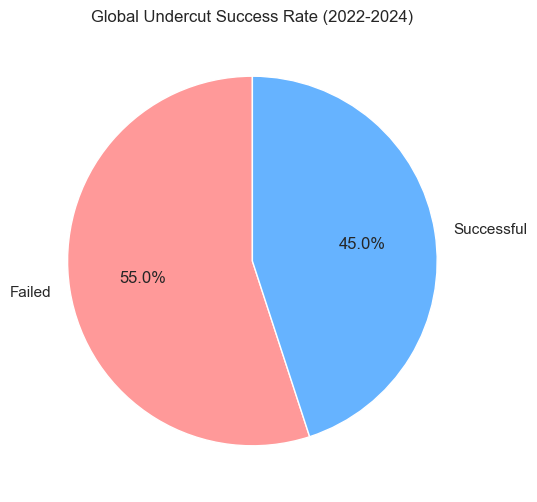

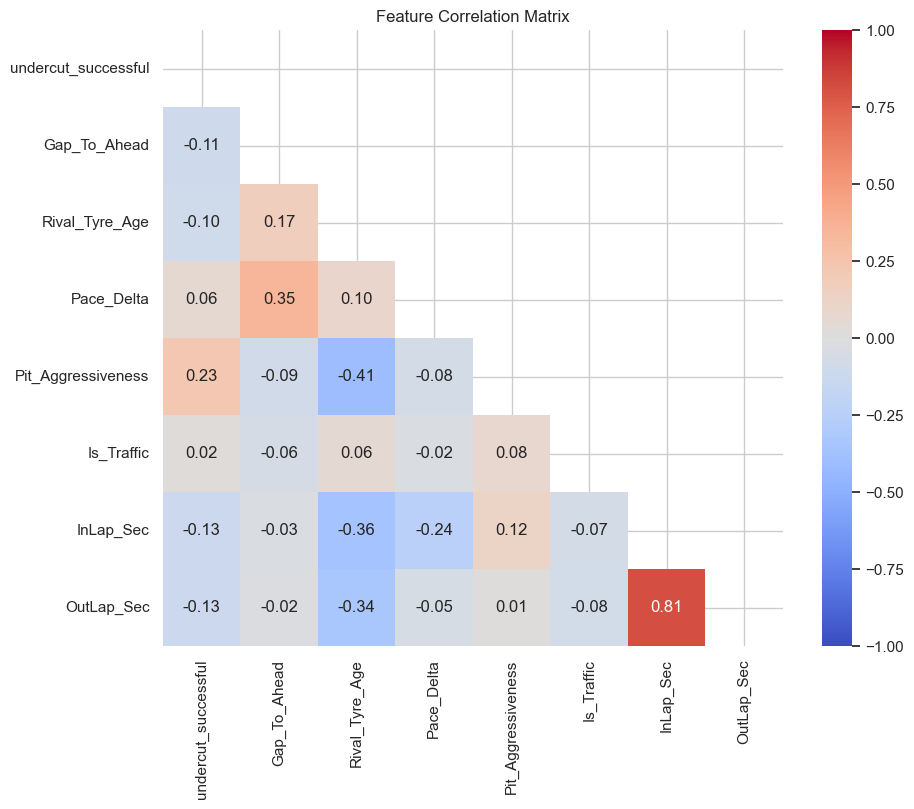

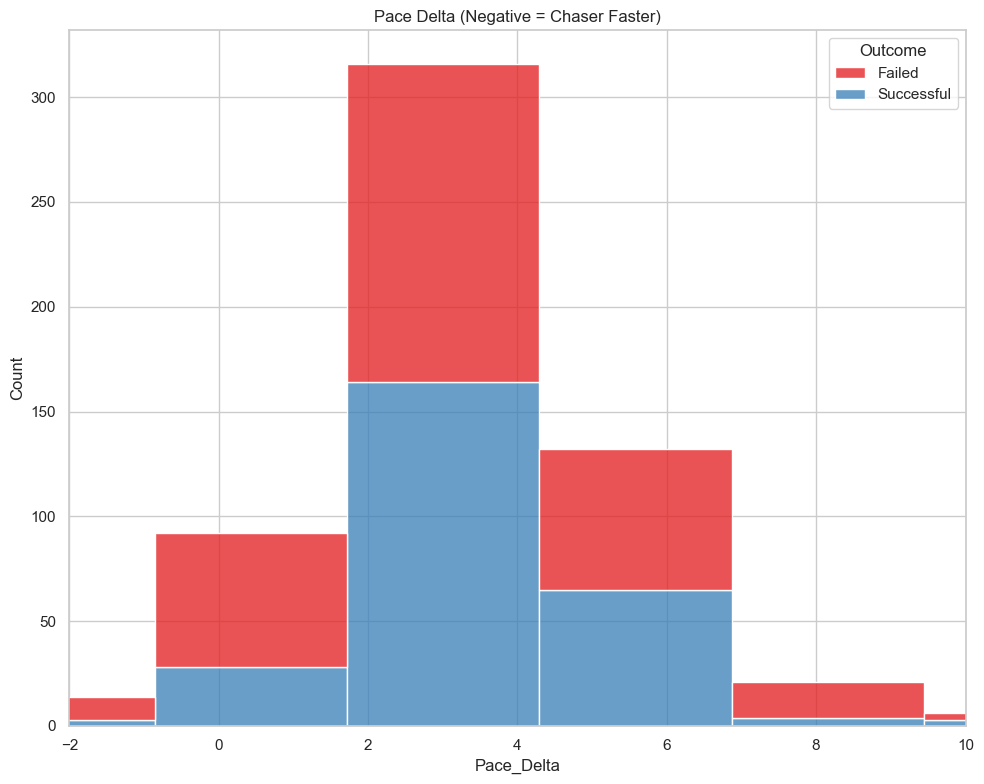

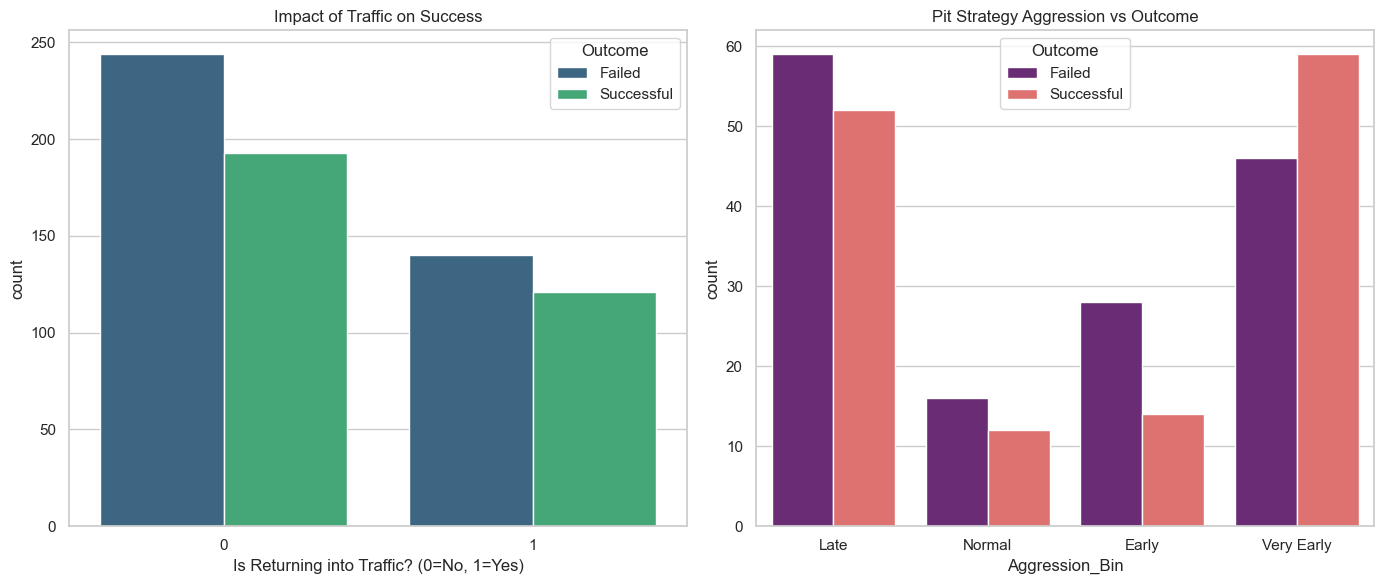

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the processed data
filename = 'f1_undercut_data_full_2.csv'

try:
    df = pd.read_csv(filename)
except FileNotFoundError:
    print("Error: CSV file not found. Please run the data collection script first.")
    df = pd.DataFrame()

if not df.empty:
    # basically we just use the datas where undercuyt happened
    df_eda = df[df['is_undercut'] == 1].copy()
    df_eda['Outcome'] = df_eda['undercut_successful'].map({0: 'Failed', 1: 'Successful'})
    
    print(f"Analyzing {len(df_eda)} undercut attempts.")

    sns.set_theme(style="whitegrid")
    
    # 1. How many is sucessful compared to unsuccessful
    plt.figure(figsize=(6, 6))
    outcome_counts = df_eda['Outcome'].value_counts()
    plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', 
            colors=['#ff9999','#66b3ff'], startangle=90)
    plt.title('Global Undercut Success Rate (2022-2024)')
    plt.show()

    # Feature - Feature correlation
    plt.figure(figsize=(10, 8))
    
    corr_features = [
        'undercut_successful', 'Gap_To_Ahead', 'Rival_Tyre_Age', 
        'Pace_Delta', 'Pit_Aggressiveness', 'Is_Traffic', 
        'InLap_Sec', 'OutLap_Sec'
    ]
    
    corr_matrix = df_eda[corr_features].corr()
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Hide top triangle
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
    plt.title('Feature Correlation Matrix')
    plt.show()

    # 3. Check the impact of traffic & aggression
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plotting does traffic affect undercut
    sns.countplot(data=df_eda, x='Is_Traffic', hue='Outcome', palette='viridis', ax=axes[0])
    axes[0].set_title('Impact of Traffic on Success')
    axes[0].set_xlabel('Is Returning into Traffic? (0=No, 1=Yes)')
    
    # Plot does pitting early help
    df_eda['Aggression_Bin'] = pd.cut(df_eda['Pit_Aggressiveness'], bins=[-10, -2, 0, 2, 10], labels=['Late', 'Normal', 'Early', 'Very Early'])
    
    sns.countplot(data=df_eda, x='Aggression_Bin', hue='Outcome', palette='magma', ax=axes[1])
    axes[1].set_title('Pit Strategy Aggression vs Outcome')
    
    plt.tight_layout()
    plt.show()

else:
    print("Dataframe is empty. EDA skipped.")

In [ ]:
df.head()

,Year,GP,Driver,Rival,Gap_To_Ahead,Rival_Tyre_Age,Pace_Delta,Pit_Aggressiveness,Is_Traffic,InLap_Sec,OutLap_Sec,is_undercut,undercut_successful
0,2022,Bahrain Grand Prix,VER,LEC,6.148,14.0,2.421,21.400000,0,117.409,96.905,1,0
1,2022,Bahrain Grand Prix,VER,LEC,6.360,18.0,2.183,5.400000,0,117.239,96.527,1,0
2,2022,Bahrain Grand Prix,VER,LEC,7.390,12.0,2.441,-17.952381,0,117.242,95.747,1,0
3,2022,Bahrain Grand Prix,GAS,MAG,1.310,14.0,-0.239,21.400000,1,121.397,98.705,0,0
4,2022,Bahrain Grand Prix,GAS,HAM,7.807,5.0,4.015,-6.952381,0,120.808,97.324,0,0



--- Training Undercut Predictor ---
Training on 592 confirmed undercut attempts.
=== Starting Model Comparison ===

Training Logistic Regression...
--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.84      0.81      0.82        58
           1       0.83      0.85      0.84        61

    accuracy                           0.83       119
   macro avg       0.83      0.83      0.83       119
weighted avg       0.83      0.83      0.83       119

Training SVM (RBF Kernel)...
--- SVM (RBF Kernel) Performance ---
              precision    recall  f1-score   support

           0       0.85      0.76      0.80        58
           1       0.79      0.87      0.83        61

    accuracy                           0.82       119
   macro avg       0.82      0.81      0.81       119
weighted avg       0.82      0.82      0.81       119

Training Gradient Boosting...
--- Gradient Boosting Performance ---
              precision

/var/folders/dg/wthjcx3j18j_h0hp3mq5vvv00000gn/T/ipykernel_72954/147066184.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, ax=axes_imp[i], palette='viridis')
/var/folders/dg/wthjcx3j18j_h0hp3mq5vvv00000gn/T/ipykernel_72954/147066184.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, ax=axes_imp[i], palette='viridis')


Training KNN...
--- KNN Performance ---
              precision    recall  f1-score   support

           0       0.87      0.67      0.76        58
           1       0.74      0.90      0.81        61

    accuracy                           0.79       119
   macro avg       0.80      0.79      0.79       119
weighted avg       0.80      0.79      0.79       119

Training Naive Bayes...
--- Naive Bayes Performance ---
              precision    recall  f1-score   support

           0       0.95      0.36      0.53        58
           1       0.62      0.98      0.76        61

    accuracy                           0.68       119
   macro avg       0.79      0.67      0.64       119
weighted avg       0.78      0.68      0.65       119

Training Random Forest...
--- Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.85      0.76      0.80        58
           1       0.79      0.87      0.83        61

    accuracy              

/var/folders/dg/wthjcx3j18j_h0hp3mq5vvv00000gn/T/ipykernel_72954/147066184.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, ax=axes_imp[i], palette='viridis')


Saving plots...


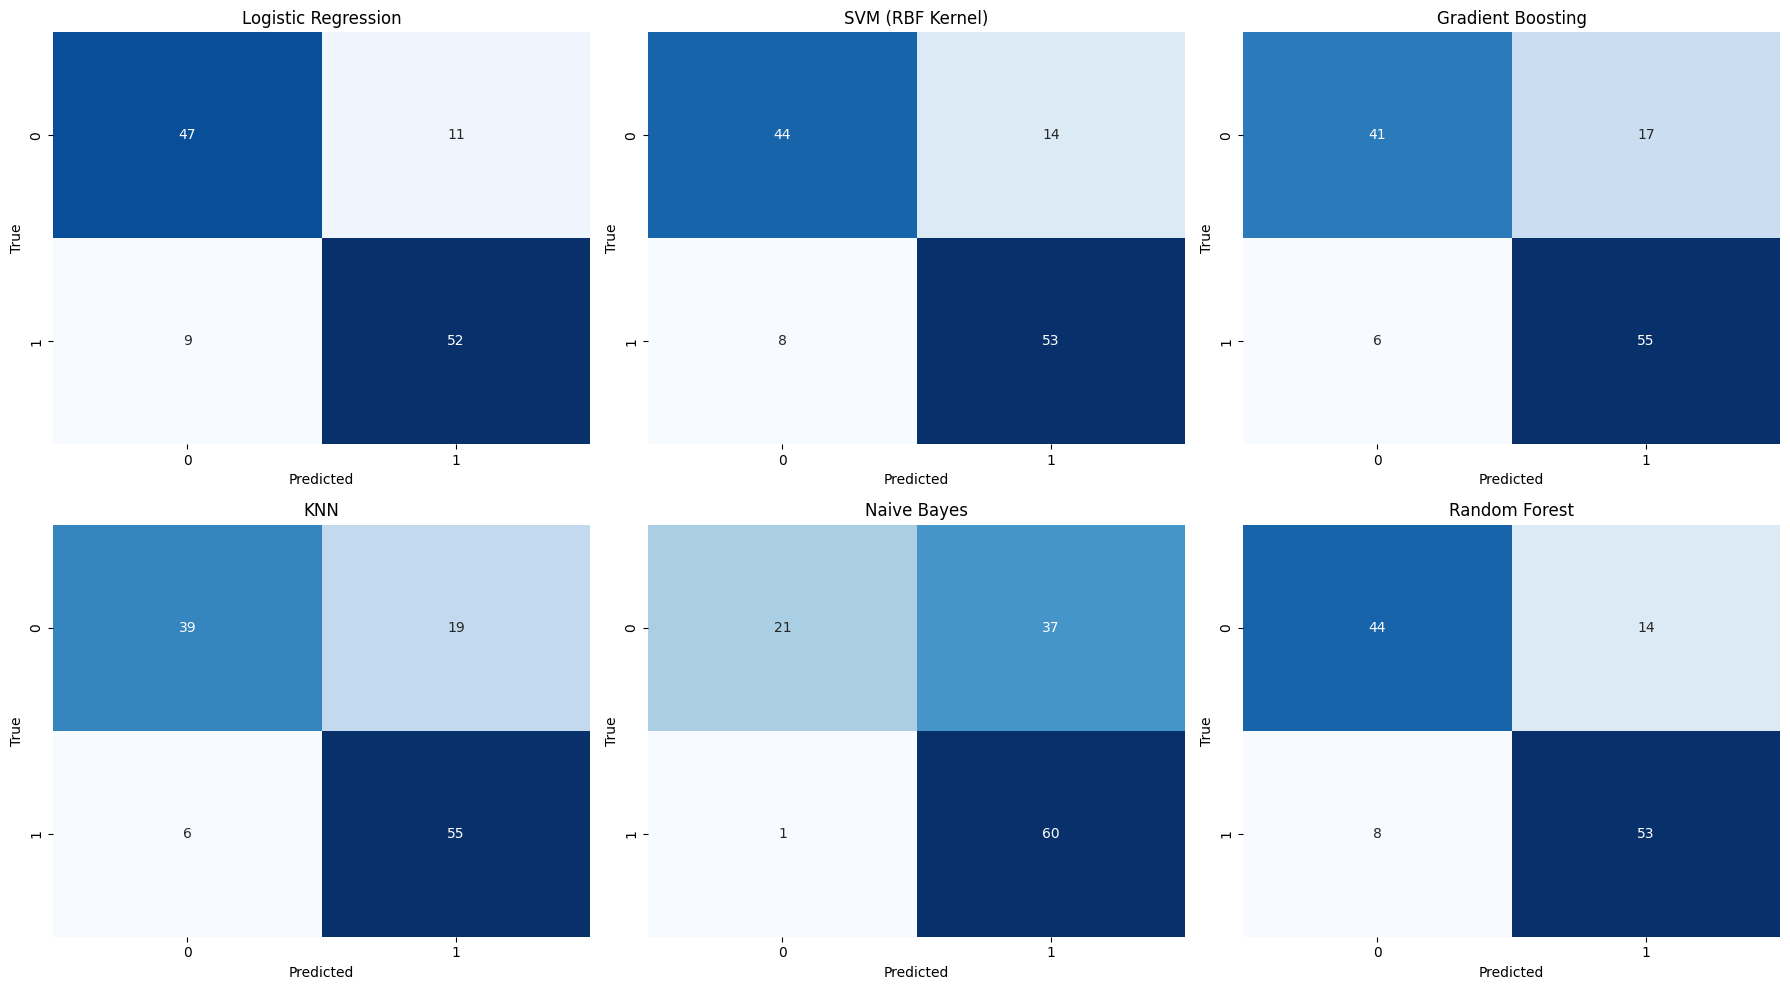

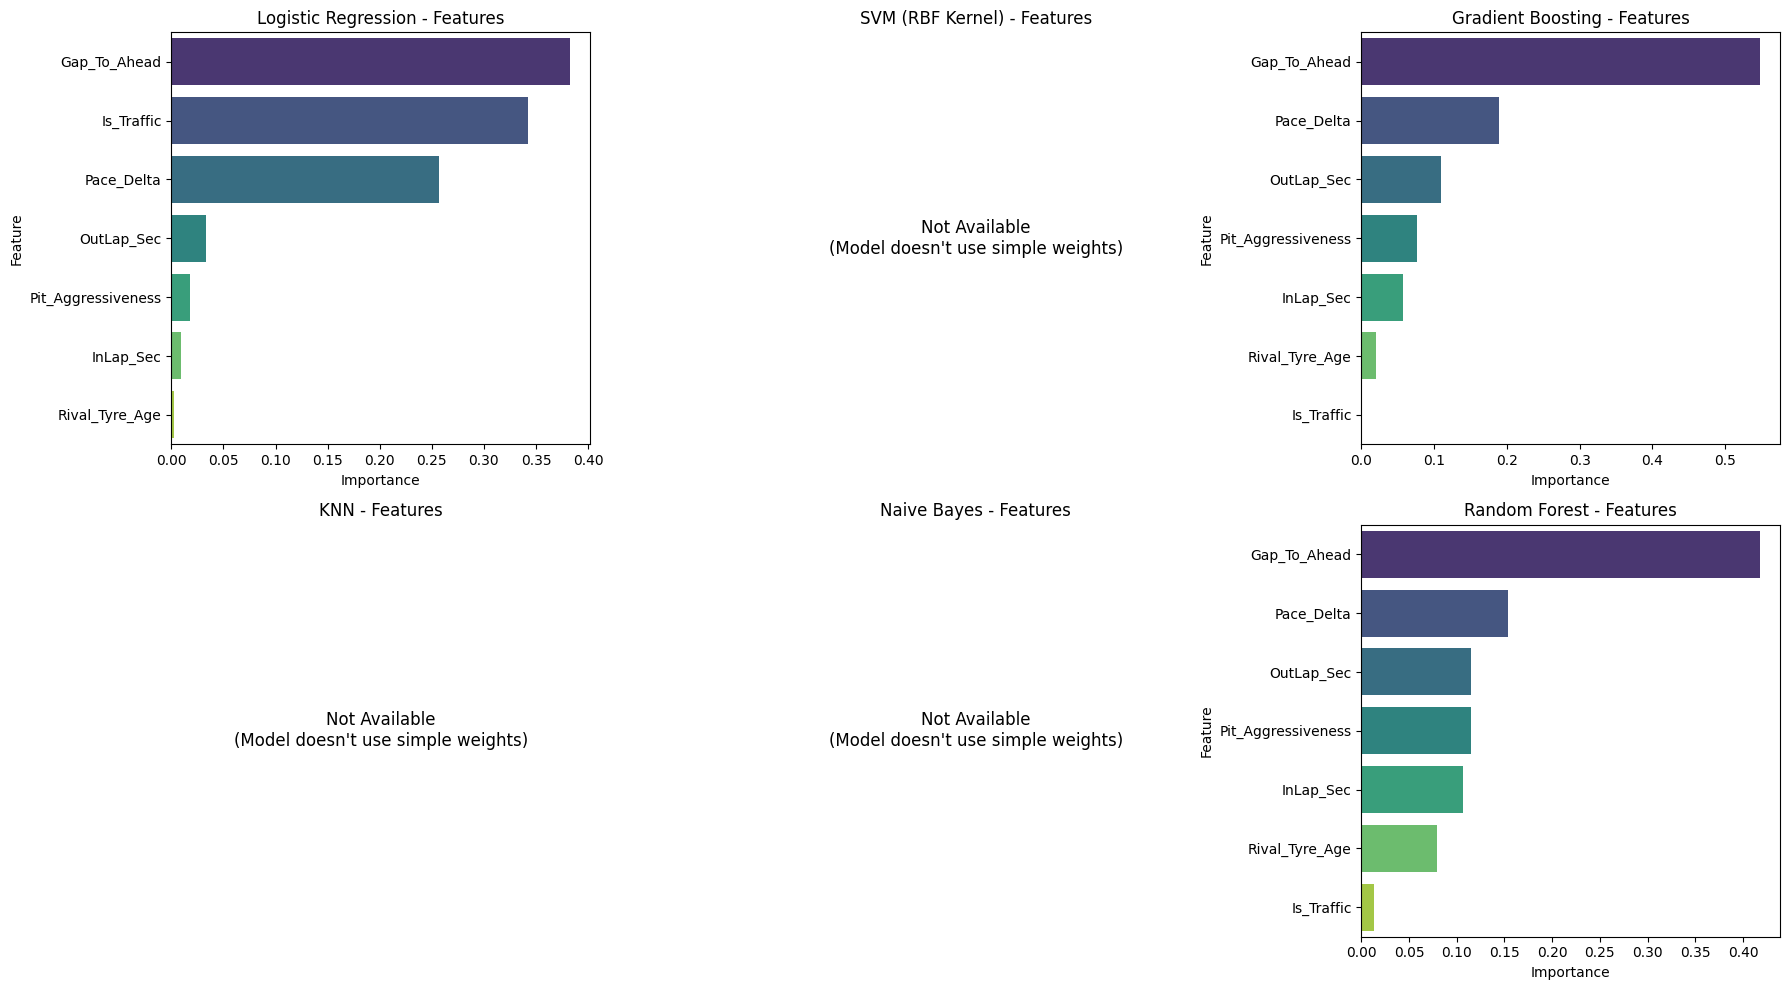

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 
from sklearn.impute import SimpleImputer
import numpy as np
import seaborn as sns
import pandas as pd

# Assume 'df' is your loaded DataFrame
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean') # Defined inside if needed

if not df.empty:
    print("\n--- Training Undercut Predictor ---")
    
    # 1. Filter: Train ONLY on rows where an undercut was actually attempted
    df_model = df[df['is_undercut'] == 1].copy()
    
    if len(df_model) == 0:
        print("No undercut attempts found in the dataset.")
    else:
        # Remove rows where critical timing data is missing
        df_model.dropna(subset=['InLap_Sec', 'OutLap_Sec', 'Gap_To_Ahead'], inplace=True)
        
        print(f"Training on {len(df_model)} confirmed undercut attempts.")
        
        CORE_FEATURES = [
            'Gap_To_Ahead',
            'Rival_Tyre_Age',
            'Pace_Delta',
            'Pit_Aggressiveness',
            'Is_Traffic',
            'InLap_Sec',
            'OutLap_Sec'
        ]
        
        X = df_model[CORE_FEATURES]
        y = df_model['undercut_successful']
        
        # 3. Train/Test Split
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Impute
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)

        # Dictionary of models
        models = {
            "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
            "SVM (RBF Kernel)": SVC(kernel='rbf', random_state=42),
            "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
            "KNN": KNeighborsClassifier(n_neighbors=5),
            "Naive Bayes": GaussianNB(),
            "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
        }

        print("=== Starting Model Comparison ===\n")

        # Setup Figure 1: Confusion Matrices
        fig_cm, axes_cm = plt.subplots(2, 3, figsize=(18, 10))
        axes_cm = axes_cm.flatten()
        
        # Setup Figure 2: Feature Importances
        fig_imp, axes_imp = plt.subplots(2, 3, figsize=(18, 10))
        axes_imp = axes_imp.flatten()

        i = 0
        for name, model in models.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)
            
            # --- EVALUATION ---
            y_pred = model.predict(X_test)
            print(f"--- {name} Performance ---")
            print(classification_report(y_test, y_pred))
            
            # 1. Plot Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes_cm[i], cbar=False)
            axes_cm[i].set_title(f"{name}", fontsize=12)
            axes_cm[i].set_xlabel('Predicted')
            axes_cm[i].set_ylabel('True')

            # 2. Plot Feature Importance (If Available)
            importances = None
            
            if hasattr(model, 'feature_importances_'):
                # Tree-based models
                importances = model.feature_importances_
            elif hasattr(model, 'coef_'):
                # Linear models (Logistic Regression) - take absolute value
                importances = abs(model.coef_[0])
            
            if importances is not None:
                # Create DataFrame for plotting
                feat_df = pd.DataFrame({
                    'Feature': CORE_FEATURES,
                    'Importance': importances
                }).sort_values(by='Importance', ascending=False)
                
                sns.barplot(x='Importance', y='Feature', data=feat_df, ax=axes_imp[i], palette='viridis')
                axes_imp[i].set_title(f"{name} - Features", fontsize=12)
            else:
                # Handle models without feature importance (KNN, NB, RBF SVM)
                axes_imp[i].text(0.5, 0.5, "Not Available\n(Model doesn't use simple weights)", 
                                 horizontalalignment='center', verticalalignment='center', fontsize=12)
                axes_imp[i].set_title(f"{name} - Features", fontsize=12)
                axes_imp[i].axis('off')

            i += 1

        # Save and Show
        print("Saving plots...")
        fig_cm.tight_layout()
        fig_cm.savefig('model_comparison_confusion_matrix.png')
        
        fig_imp.tight_layout()
        fig_imp.savefig('model_comparison_feature_importance.png')
        
        plt.show() # Show immediately in notebook
else:
    print("Script finished without data.")